# Model from Scratch

In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from IPython import display

In [ ]:
# Download the data zip file from Google Drive.
!gdown --id 1mprgnl4zHl_GvtAPMo9TqwW5TbP3VpRH

Downloading...
From: https://drive.google.com/uc?id=1mprgnl4zHl_GvtAPMo9TqwW5TbP3VpRH
To: /content/mini_speech_commands.zip
178MB [00:02, 76.8MB/s]


In [ ]:
# Unzip the data file.
!unzip -n mini_speech_commands.zip

Streaming output truncated to the last 5000 lines.
  inflating: mini_speech_commands/no/b87bdb22_nohash_1.wav  
  inflating: mini_speech_commands/no/97f4c236_nohash_2.wav  
  inflating: mini_speech_commands/no/563aa4e6_nohash_2.wav  
  inflating: mini_speech_commands/no/51055bda_nohash_4.wav  
  inflating: mini_speech_commands/no/fac74f6a_nohash_1.wav  
  inflating: mini_speech_commands/no/708a9569_nohash_1.wav  
  inflating: mini_speech_commands/no/a5609cce_nohash_0.wav  
  inflating: mini_speech_commands/no/686d030b_nohash_1.wav  
  inflating: mini_speech_commands/no/8012c69d_nohash_3.wav  
  inflating: mini_speech_commands/no/dc75148d_nohash_0.wav  
  inflating: mini_speech_commands/no/8134f43f_nohash_0.wav  
  inflating: mini_speech_commands/no/712e4d58_nohash_2.wav  
  inflating: mini_speech_commands/no/b43c8f2f_nohash_1.wav  
  inflating: mini_speech_commands/no/c0445658_nohash_4.wav  
  inflating: mini_speech_commands/no/9080f6d3_nohash_0.wav  
  inflating: mini_speech_commands/

In [ ]:
!ls mini_speech_commands/

down  go  left	no  README.md  right  stop  up	yes


In [ ]:
male_files = tf.io.gfile.glob(str(pathlib.Path('mini_speech_commands')) + '/*/male/*.wav')
female_files = tf.io.gfile.glob(str(pathlib.Path('mini_speech_commands')) + '/*/female/*.wav')
all_files = male_files + female_files
np.random.shuffle(all_files)

In [ ]:
print(male_files[0:2])
print(female_files[0:2])
print(len(all_files))

['mini_speech_commands/yes/male/3ac2e76f_nohash_0.wav', 'mini_speech_commands/yes/male/2aec99ec_nohash_0.wav']
['mini_speech_commands/yes/female/1c6e5447_nohash_0.wav', 'mini_speech_commands/yes/female/004ae714_nohash_0.wav']
823


In [ ]:
train_files = all_files[:700]
val_files = all_files[700:780]
test_files = all_files[780:]

In [ ]:
def extract(file_path):
  binary = tf.io.read_file(file_path)
  audio, _ = tf.audio.decode_wav(binary)
  waveform = tf.squeeze(audio, axis=-1)
  label = tf.strings.split(file_path, os.path.sep)[-2]
  return waveform, label

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(all_files).map(extract, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
a, l = iter(dataset.skip(4).take(1)).next()
print(a.shape)
print(l)
display.display(display.Audio(a, rate=16000))

(10240,)
tf.Tensor(b'male', shape=(), dtype=string)


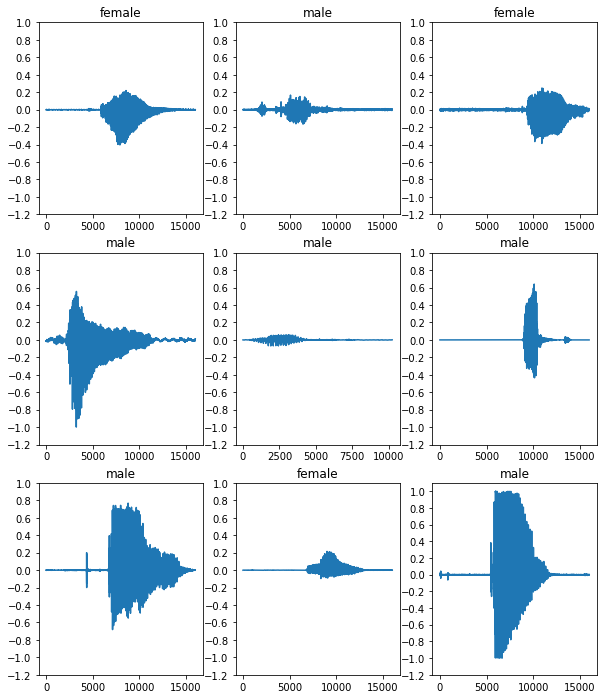

In [ ]:
rows = 3
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (a, l) in enumerate(dataset.take(9)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(a.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  ax.set_title(l.numpy().decode('utf-8'))
  

plt.show()

In [ ]:
def spectrogram(waveform, label):
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
  waveform = tf.cast(waveform, tf.float32)
  padded = tf.concat([waveform, zero_padding], 0)
  spec = tf.signal.stft(padded, frame_length=255, frame_step=128)
  spec = tf.expand_dims(spec, -1)
  # spec is a complex number
  spec = tf.abs(spec)
  return spec, tf.cond(label == 'female', lambda: tf.constant(0, dtype=tf.int32), lambda: tf.constant(1, dtype=tf.int32))

In [ ]:
s_dataset = dataset.map(spectrogram, num_parallel_calls=tf.data.AUTOTUNE)

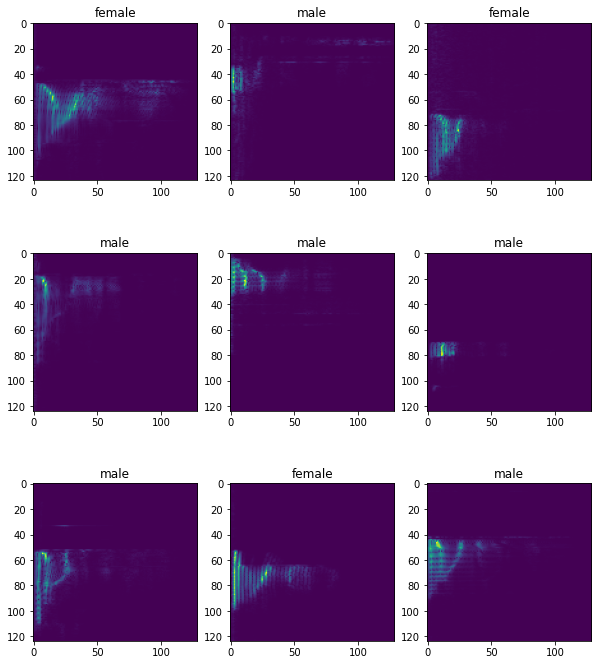

In [ ]:
rows = 3
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (a, l) in enumerate(s_dataset.take(9)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.imshow(np.squeeze(a.numpy()))
  ax.set_title('female' if l.numpy() == 0 else 'male')
  

plt.show()

In [ ]:
a, l = iter(s_dataset.take(1)).next()
print(a.shape)
print(l)

(124, 129, 1)
tf.Tensor(0, shape=(), dtype=int32)


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(train_files).map(extract, num_parallel_calls=tf.data.AUTOTUNE).map(spectrogram, num_parallel_calls=tf.data.AUTOTUNE).batch(32).cache().prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices(val_files).map(extract, num_parallel_calls=tf.data.AUTOTUNE).map(spectrogram, num_parallel_calls=tf.data.AUTOTUNE).batch(32).cache().prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices(test_files).map(extract, num_parallel_calls=tf.data.AUTOTUNE).map(spectrogram, num_parallel_calls=tf.data.AUTOTUNE).batch(32).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(124, 129, 1)),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1, activation='sigmoid'),
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 122, 127, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 61, 63, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 61, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 59, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 29, 30, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 29, 30, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 55680)            

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=['accuracy'],
)

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5, restore_best_weights=True))

Epoch 1/20
22/22 [==============================] - 2s 48ms/step - loss: 0.7628 - accuracy: 0.5720 - val_loss: 0.6201 - val_accuracy: 0.8500
Epoch 2/20
22/22 [==============================] - 1s 36ms/step - loss: 0.5691 - accuracy: 0.7474 - val_loss: 0.4826 - val_accuracy: 0.8000
Epoch 3/20
22/22 [==============================] - 1s 36ms/step - loss: 0.4765 - accuracy: 0.7930 - val_loss: 0.3870 - val_accuracy: 0.8750
Epoch 4/20
22/22 [==============================] - 1s 36ms/step - loss: 0.3484 - accuracy: 0.8756 - val_loss: 0.3989 - val_accuracy: 0.8750
Epoch 5/20
22/22 [==============================] - 1s 36ms/step - loss: 0.2553 - accuracy: 0.9009 - val_loss: 0.2897 - val_accuracy: 0.9000
Epoch 6/20
22/22 [==============================] - 1s 36ms/step - loss: 0.1589 - accuracy: 0.9462 - val_loss: 0.3020 - val_accuracy: 0.9000
Epoch 7/20
22/22 [==============================] - 1s 36ms/step - loss: 0.1734 - accuracy: 0.9272 - val_loss: 0.3665 - val_accuracy: 0.8375
Epoch 8/20
22

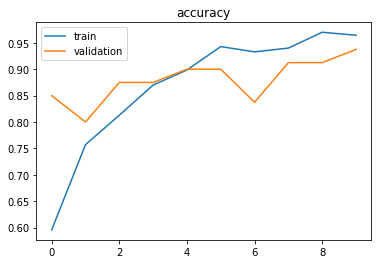

In [ ]:
plt.plot(history.epoch, history.history['accuracy'], history.history['val_accuracy'])
plt.legend(['train', 'validation'])
plt.title('accuracy')
plt.show()

In [ ]:
model.evaluate(test_ds)

2/2 [==============================] - 0s 9ms/step - loss: 0.3458 - accuracy: 0.8837


[0.34584710001945496, 0.8837209343910217]

In [ ]:
errors = []
for f in test_files:
  w, lt = extract(f)
  s, l = spectrogram(w, lt)
  prob = tf.squeeze(model(tf.expand_dims(s, axis=0)))
  if tf.abs(prob - tf.cast(tf.squeeze(l), dtype=tf.float32)).numpy() > 0.5:
    errors.append((w, lt.numpy().decode('utf-8'), prob.numpy()))
print(len(errors))

5


In [ ]:
for w, l, p in errors:
  print('Label: {}; prediction: {}'.format(l, p))
  display.display(display.Audio(w, rate=16000))

Label: male; prediction: 0.03889978677034378


Label: male; prediction: 0.09424557536840439


Label: female; prediction: 0.6757497191429138


Label: male; prediction: 0.2559598386287689


Label: female; prediction: 0.5047611594200134


# Try Transfer Learning

In [ ]:
import tensorflow_hub as hub

In [ ]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [ ]:
def extract_t(file_path):
  binary = tf.io.read_file(file_path)
  audio, _ = tf.audio.decode_wav(binary)
  waveform = tf.squeeze(audio, axis=-1)
  label = tf.strings.split(file_path, os.path.sep)[-2]
  l = tf.cond(label == 'female', lambda: tf.constant(0, dtype=tf.int32), lambda: tf.constant(1, dtype=tf.int32))
  _, embeddings, _ = yamnet_model(waveform)
  num = tf.shape(embeddings)[0]
  return embeddings, tf.repeat(l, num)

In [ ]:
model_t = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(1024), dtype=tf.float32),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid'),
])
model_t.summary()
model_t.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 525,313
Trainable params: 525,313
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_t_ds = tf.data.Dataset.from_tensor_slices(train_files).map(extract_t, num_parallel_calls=tf.data.AUTOTUNE).unbatch().batch(32).cache().prefetch(tf.data.AUTOTUNE)
val_t_ds = tf.data.Dataset.from_tensor_slices(val_files).map(extract_t, num_parallel_calls=tf.data.AUTOTUNE).unbatch().batch(32).cache().prefetch(tf.data.AUTOTUNE)
test_t_ds = tf.data.Dataset.from_tensor_slices(test_files).map(extract_t, num_parallel_calls=tf.data.AUTOTUNE).unbatch().batch(32).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
history_t = model_t.fit(train_t_ds, epochs=20, validation_data=val_t_ds, callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5, restore_best_weights=True))

Epoch 1/20
42/42 [==============================] - 16s 372ms/step - loss: 0.6379 - accuracy: 0.6405 - val_loss: 0.5360 - val_accuracy: 0.7468
Epoch 2/20
42/42 [==============================] - 0s 9ms/step - loss: 0.4530 - accuracy: 0.8046 - val_loss: 0.4849 - val_accuracy: 0.7722
Epoch 3/20
42/42 [==============================] - 0s 9ms/step - loss: 0.3940 - accuracy: 0.8342 - val_loss: 0.4724 - val_accuracy: 0.7722
Epoch 4/20
42/42 [==============================] - 0s 9ms/step - loss: 0.3593 - accuracy: 0.8465 - val_loss: 0.4627 - val_accuracy: 0.7785
Epoch 5/20
42/42 [==============================] - 0s 10ms/step - loss: 0.3304 - accuracy: 0.8607 - val_loss: 0.4556 - val_accuracy: 0.7785
Epoch 6/20
42/42 [==============================] - 0s 9ms/step - loss: 0.3065 - accuracy: 0.8814 - val_loss: 0.4573 - val_accuracy: 0.7911
Epoch 7/20
42/42 [==============================] - 0s 9ms/step - loss: 0.2853 - accuracy: 0.8877 - val_loss: 0.4531 - val_accuracy: 0.7848
Epoch 8/20
42/42

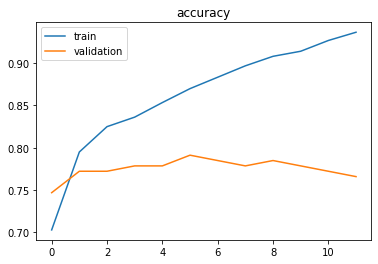

In [ ]:
plt.plot(history_t.epoch, history_t.history['accuracy'], history_t.history['val_accuracy'])
plt.legend(['train', 'validation'])
plt.title('accuracy')
plt.show()

In [ ]:
model_t.evaluate(test_t_ds)

3/3 [==============================] - 2s 251ms/step - loss: 0.4174 - accuracy: 0.7595


[0.41735830903053284, 0.7594936490058899]